In [61]:
from speck import SpeckCipher
import sys
import os

import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import json

import matplotlib.pyplot as plt

pd.options.display.max_columns = None
uploadFormat = True
numOfChunks = 60

In [2]:
# the name of the directory where the files are stored
# if you have downloaded this off git you will need to change this!
directory_in_str = '/home/lifegarb/Documents/Work/Projects/211025_Voi_scooter_feasiability/data/on_bike/231019'

# before converting to a data frame, all the data is going to go into a list of dicts, this list is called:
data = []

# and this is decode key for the spec incryption
key_string = '{0xad, 0x1c, 0x4b, 0x6, 0x5c, 0x85, 0x2a, 0x48, 0xe4, 0xed, 0x33, 0x23, 0x4c, 0x9f, 0xed, 0x56, 0x23, 0x46, 0x59, 0xfa, 0x3c, 0x70, 0x82, 0x97, 0x45, 0xbd, 0x2b, 0xf1, 0xdc, 0xf4, 0xb6, 0xce}'

# the key string format above is how the teensy needs in, we convert it into an int for python thusly:
# we can convert into somethign this code can use by doing this:
key = [int(i,16) for i in key_string[1:-1].split(',')]

# and now with the key wecan set up our Speck Decryptre
my_speck = SpeckCipher(int.from_bytes(bytes(key), byteorder='big'), key_size=256, block_size=128)

In [3]:
def ddmm_to_degrees(ddmm):
    degrees, minutes = ddmm.astype('float64').divmod(100)
    return (degrees + minutes/60)

def missing_data(series):
    return series == '-'

In [4]:
directory = os.fsencode(directory_in_str)

# we are going to iterate through the files
for fileBytes in os.listdir(directory):
    # get the name of the file, to see if it has the correct extention 
    filename = os.fsdecode(fileBytes)
    # and if it does, we process it
    if filename.endswith(".bin"):
        print('Checking {}'.format(filename))
        with open(os.path.join(directory, fileBytes), 'r') as file:
            line_count = 0
            # go through the file line by line
            # check the line isn't blank
            for line in file:
                if line == '\n':
                    continue
                if uploadFormat:
                    # this means that the file is in the funny format that you seem to get when
                    # uploading via Strings from the sensor to James's server. We have to convert 
                    # it into the normal format
                    while True:
                        line_part = file.readline()
                        if (line_part == '\n' or line_part == ''):
                            break
                        line = line.strip() + line_part.strip();
                # we need a line encramter so that we can tell the user where there are errors
                line_count = line_count + 1
                # and this is going to be the string into which we save the decoded ascii
                DecodedAsciiLine = ''

                # each line is encoded into a number of encoded chunks, at the moment that number is 60,
                # although it might change so I've put it in a variable.
                for i in range(numOfChunks):
                    encChunk = line[i*32:(i*32)+32]
                    try:
                        CipherTextChunk = int(encChunk, 16)
                    except ValueError:
                        print("Could not convert to int in {}, line {}, chunk {}, could not decrypt".format(
                            filename,line_count,i), 
                            file=sys.stderr)
                    PlaneTextChunk = hex(my_speck.decrypt(CipherTextChunk))

                    # now decode the hex to ascii

                    # so the message ends with guff, so we have to look out for the nulll byte,
                    # which signifies the end.
                    # convert to a byte array
                    # we cut off the first two characters because they are the '0x' signifing hex
                    try:
                        PlaneByteArray =  bytearray.fromhex(PlaneTextChunk[2:])
                    except ValueError:
                        print("Non-Hex Value found in line {}, chunk {}, could not decrypt".format(
                            filename,line_count,i), 
                            file=sys.stderr)
                        AsciiChunk = ''
                    # look for the null character
                    nullLoc = PlaneByteArray.find(b'\00')

                    # if the location returned is 0 or higher then there is a null character in there
                    # and we must ignore everything after it
                    if (nullLoc > -1):
                        try:
                            AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:])[0:nullLoc].decode()
                        except UnicodeDecodeError:
                            print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                filename, line_count, i), file=sys.stderr)
                            AsciiChunk = ''
                        except ValueError:
                            print("Non-Hex Value found in {}, line {}, chunk {}, could not convert to ascii".format(
                                filename, line_count,i), 
                                file=sys.stderr)
                            AsciiChunk = ''
                    else:
                        try:
                            AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:]).decode()
                        except UnicodeDecodeError:
                            print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                filename, line_count, i), file=sys.stderr)
                            AsciiChunk = ''
                        except ValueError:
                            print("Non-Hex Value found in line {}, chunk {}, could not convert to ascii".format(
                                filename, line_count,i), 
                                file=sys.stderr)
                            AsciiChunk = ''
                    # and concat the new block onto the exisiting string
                    DecodedAsciiLine = DecodedAsciiLine + AsciiChunk

                    # if we found the null character then we have reached the end of the message and can 
                    # break the loop
                    if (nullLoc > -1):
                        break
                # now we are going to try and decode the json string and convert it into a nested data structure
                try:
                    data.append(json.loads(DecodedAsciiLine.strip()))
                except ValueError:
                    # if it doesn't work, then try and output it.
                    print('Error Decoding JSON in {}, on line {}'.format(filename, line_count),
                          file=sys.stderr
                         )
            continue
    else:
        continue

Checking 20231019_092646_8534.bin


Error in 20231019_092646_8534.bin, line 3, chunk 35, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 36, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 37, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 38, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 39, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 40, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 41, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 42, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 43, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 44, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 45, count not convert to ascii
Error in 20231019_092646_8534.bin, line 3, chunk 46, count not convert to ascii
Error in 20231019_092646_8534.bin, line 

Checking 20231018_175806_6829.bin
Checking 20231018_175821_2340.bin
Checking 20231019_092702_2452.bin


Error Decoding JSON in 20231018_175806_6829.bin, on line 18
Error Decoding JSON in 20231018_175806_6829.bin, on line 37
Error Decoding JSON in 20231018_175806_6829.bin, on line 54
Error Decoding JSON in 20231018_175806_6829.bin, on line 71
Error Decoding JSON in 20231018_175806_6829.bin, on line 107
Error Decoding JSON in 20231018_175806_6829.bin, on line 115
Error Decoding JSON in 20231018_175806_6829.bin, on line 130
Error Decoding JSON in 20231018_175806_6829.bin, on line 165
Error Decoding JSON in 20231018_175806_6829.bin, on line 175
Error Decoding JSON in 20231018_175806_6829.bin, on line 179
Error Decoding JSON in 20231018_175806_6829.bin, on line 207
Error Decoding JSON in 20231018_175806_6829.bin, on line 217
Non-Hex Value found in line 20231018_175806_6829.bin, chunk 226, could not decrypt
Non-Hex Value found in line 20231018_175806_6829.bin, chunk 226, could not convert to ascii
Could not convert to int in 20231018_175806_6829.bin, line 226, chunk 8, could not decrypt
Non-He

Checking 20231019_092738_3680.bin
Checking 20231018_175845_6855.bin


Error Decoding JSON in 20231019_092738_3680.bin, on line 2
Error Decoding JSON in 20231019_092738_3680.bin, on line 19
Error Decoding JSON in 20231019_092738_3680.bin, on line 20
Error Decoding JSON in 20231019_092738_3680.bin, on line 39
Error Decoding JSON in 20231019_092738_3680.bin, on line 41
Error Decoding JSON in 20231019_092738_3680.bin, on line 62
Error Decoding JSON in 20231019_092738_3680.bin, on line 78
Error Decoding JSON in 20231019_092738_3680.bin, on line 91
Error Decoding JSON in 20231019_092738_3680.bin, on line 105
Error Decoding JSON in 20231019_092738_3680.bin, on line 112
Error Decoding JSON in 20231019_092738_3680.bin, on line 136
Error Decoding JSON in 20231019_092738_3680.bin, on line 178
Error Decoding JSON in 20231019_092738_3680.bin, on line 183
Error Decoding JSON in 20231019_092738_3680.bin, on line 214
Error Decoding JSON in 20231018_175845_6855.bin, on line 14
Error in 20231018_175845_6855.bin, line 19, chunk 35, count not convert to ascii
Error in 20231

In [5]:
df = pd.DataFrame(data)

In [14]:
df_flat = pd.concat([pd.to_datetime(df.datetime), 
           pd.json_normalize(df.GPS), 
           pd.json_normalize(df.DHT), 
           pd.json_normalize(df.MultiGas),
           pd.json_normalize(df.PM_Sensor)
          ], axis=1)

df_flat = df_flat.mask(missing_data)
#data = data.convert_dtypes()
df_flat = df_flat.dropna()
#df_flat = df_flat.droplevel(level=0, axis=1)

In [54]:
df_flat

,datetime,fix,speed,angle,satellites,location.lat,location.long,location.alt,humidity,temp,heat_index,no2,c2h5ch,voc,co,atmos_enviro.AE_1.0,atmos_enviro.AE_2.5,atmos_enviro.AE_10.0,geometry
0,2023-10-19 07:28:24+00:00,True,2.43,262.559998,12,5127.496582,232.3004,69.099998,84.6,14.1,13.77,496,564,773,120,6,8,10,POINT (-2.53834 51.45828)
1,2023-10-19 07:28:29+00:00,True,2.43,262.559998,12,5127.496582,232.305801,68.900002,87.3,14.1,13.84,469,524,749,113,6,8,12,POINT (-2.53843 51.45828)
2,2023-10-19 07:28:34+00:00,True,3.19,281.73999,12,5127.498535,232.313004,68.900002,87.7,14.2,13.97,428,505,715,115,7,9,12,POINT (-2.53855 51.45831)
3,2023-10-19 07:28:39+00:00,True,3.19,281.73999,11,5127.499023,232.316894,68.599998,88.2,14.1,13.87,422,473,698,108,19,28,34,POINT (-2.53861 51.45832)
4,2023-10-19 07:28:44+00:00,True,2.12,296.01001,11,5127.499512,232.317902,68.599998,88.6,14.2,13.99,406,462,678,108,28,42,56,POINT (-2.53863 51.45833)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,2023-10-18 16:56:39+00:00,True,4.02,102.040001,12,5127.498535,232.319199,66.699997,85.1,13.2,12.8,75,202,95,67,19,29,37,POINT (-2.53865 51.45831)
892,2023-10-18 16:56:44+00:00,True,2.54,83.610001,12,5127.498535,232.313095,66.699997,85.2,13.2,12.8,75,203,95,67,24,29,34,POINT (-2.53855 51.45831)
893,2023-10-18 16:56:49+00:00,True,2.54,83.610001,11,5127.498047,232.306503,67.5,85.3,13.2,12.8,76,205,95,68,24,28,36,POINT (-2.53844 51.45830)
894,2023-10-18 16:56:54+00:00,True,3.38,94.690002,11,5127.497559,232.299606,67.5,85.4,13.2,12.81,76,203,96,67,22,25,32,POINT (-2.53833 51.45829)


In [15]:
df_flat = gpd.GeoDataFrame(
    df_flat, 
    # geometry=gpd.points_from_xy(data['GPS']['location.long'].pipe(ddmm_to_degrees), 
    #                             data['GPS']['location.lat'].pipe(ddmm_to_degrees), 
    geometry=gpd.points_from_xy(-df_flat['location.long'].pipe(ddmm_to_degrees), 
                                df_flat['location.lat'].pipe(ddmm_to_degrees), 
                                crs='epsg:4326')
)

In [53]:
df_flat[['satellites',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('no2', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=200,
                           style_kwds={"style_function":lambda x: {"radius": (10 - x['properties']['satellites'])*2
                                                                  }
                                                                  
                                      }
                           )

In [66]:
df_flat[['satellites',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('co', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=100,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )

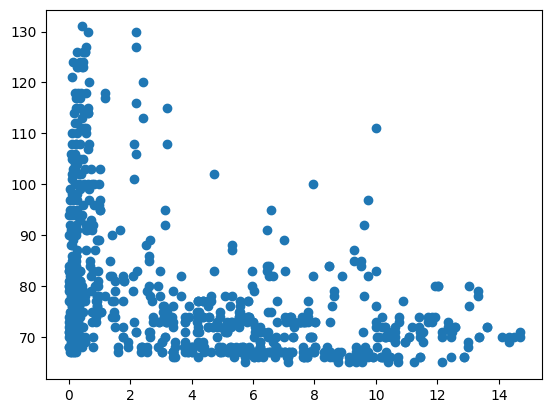

In [64]:
plt.scatter(x=df_flat['speed'], y=df_flat['co'])